In [ ]:
!pip install timm
!pip install torch torchvision
!pip install torchsummary

In [ ]:
import os
import pandas as pd
from PIL import Image
from urllib.request import urlopen
import timm
import pandas as pd
import numpy as np
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import matplotlib.pyplot as plt

import cv2
from torchsummary import summary
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

## Prepare training data

In [ ]:
root = '/kaggle/input/comp90086-2024-project-train/train'

# load the dataset
data = pd.read_csv('/kaggle/input/comp90086-2024-project-train/train.csv')

Text(0.5, 1.0, 'Stable Height Count')

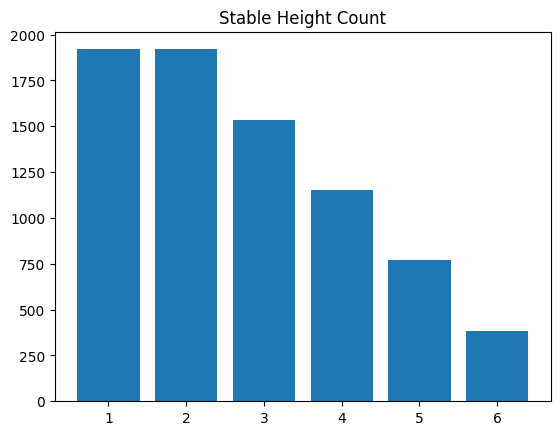

In [ ]:
# plot the class distribution in the whole dataset
x = sorted(data['stable_height'].unique())
y = data['stable_height'].value_counts().sort_index()

plt.bar(x,y)
plt.title('Stable Height Count')

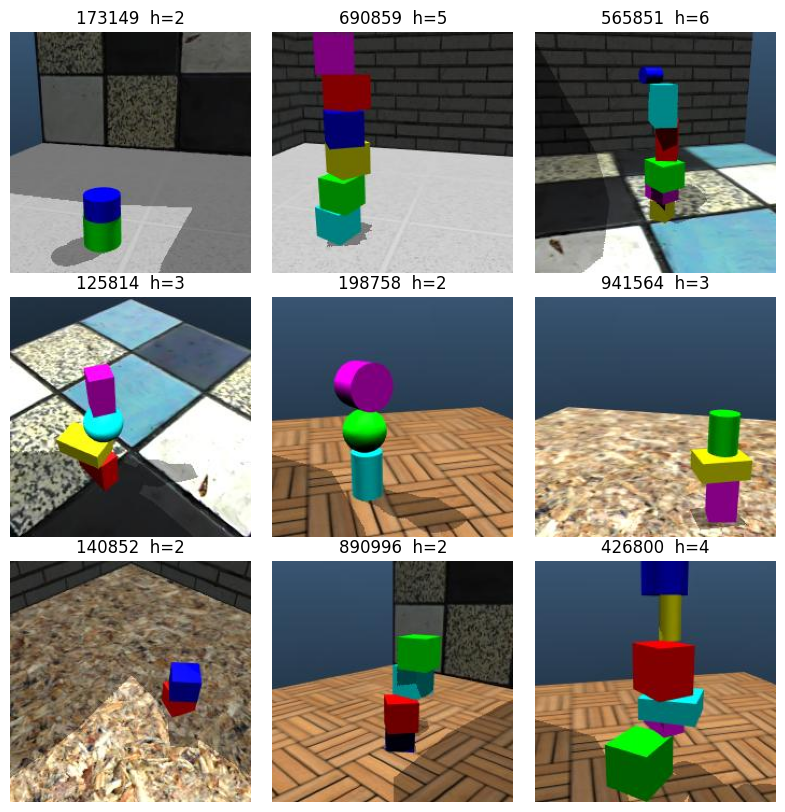

In [ ]:
# randomly display 9 images and their stable height
ids = random.sample(list(data['id']),9)

fig = plt.figure(figsize=(10, 10))
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    path = os.path.join(root, str(ids[i]) + '.jpg')
    im = plt.imread(path)
    ax = plt.imshow(im)
    
    plt.title(str(ids[i]) + '  h=' + str(data[data['id'] == ids[i]].iloc[0].stable_height))
    plt.axis('off')
    fig.subplots_adjust(wspace=0.05, hspace=0.1)

In [ ]:
# define the encoder
label_encoder = LabelEncoder()

# convert stable_height to class labels
data['stable_height'] = label_encoder.fit_transform(data['stable_height']) 
print(data['stable_height'].unique())

# split the CSV into training and validation sets with stratification; the ratio is 8:2
train_df, val_df= train_test_split(data, test_size=0.2, random_state=42, stratify=data['stable_height'])

[1 0 4 5 3 2]


In [32]:
# # compute class weights

# from sklearn.utils.class_weight import compute_class_weight

# y = train_df['stable_height']

# weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)

# weights

array([0.66666667, 0.66666667, 0.83319772, 1.11062907, 1.66775244,
       3.33550489])

## Data pre-processing

In [ ]:
# prepare the data and apply transform on it

class ImageHeightDataset(Dataset):

    def __init__(self, df, root_dir, transform)
        self.df = df                # training or validation dataframe
        self.root_dir = root_dir    # directory with images
        self.transform = transform  # transformations (like resizing, normalization, etc. Optional)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get image file name (id) and the corresponding height (stable_height)
        img_id = str(self.df.iloc[idx]['id'])
        height = self.df.iloc[idx]['stable_height']

        # construct image file path
        img_path = os.path.join(self.root_dir, img_id + '.jpg')
        image = Image.open(img_path).convert("RGB")  # convert to RGB if the image is grayscale

        # apply transformations 
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(height), int(img_id)  # return image, height and id

Model source:



Wightman, R. (2019). PyTorch image models (GitHub repository). GitHub. https://github.com/huggingface/pytorch-image-models https://doi.org/10.5281/zenodo.4414861

In [ ]:
# load the pretrained model from hugging face

def create_model(pretrained):
    # this model comes from https://github.com/huggingface/pytorch-image-models
    model = timm.create_model('resnet50.a1_in1k', pretrained=pretrained)

    # stable height contains 6 different height
    num_classes = 6 
    # number of features passed into the last fc layer of the model
    num_features = model.fc.in_features

    model.fc = nn.Sequential(
      nn.Linear(num_features, 512),   # a linear layer with 512 output features
      nn.ReLU(inplace=True),          # activation function
      nn.Dropout(0.3),                # dropout layer with 30% dropout rate 
      nn.Linear(512, 256),            # a linear layer with 256 output features
      nn.ReLU(inplace=True),         
      nn.Dropout(0.3),                
      nn.Linear(256, num_classes)     # final prediction layer for 6 classes
    )
    
    # freeze all the layers of the pretrained model
    for param in model.parameters():
        param.requires_grad = False

    # unfreeze later layers
    for param in model.layer3.parameters():
        param.requires_grad = True
    for param in model.layer4.parameters():
        param.requires_grad = True

    return model

In [ ]:
# create transforms to apply data augmentation and resize the images
# note that augmentation is performed only on the training dataset

def create_transform(model, test):
    # obtain model configuration
    data_config = timm.data.resolve_model_data_config(model)

    if test: # transform for validation and test set (without data augmentation)
        transform = timm.data.create_transform(**data_config, is_training=False)
        
    else:    # transform for training set (with data augmentation)
        transform = timm.data.create_transform(**data_config, is_training=True)
    return transform

In [ ]:
# create data augmentation transform and display the augmented images

# note that augmentation is performed only on the training dataset

def data_augmentation(transform, data):
    # set the fill color for padding images to black
    fill = (0,0,0)

    # create transformation objects
    trivial_aug = transforms.TrivialAugmentWide(fill=fill)
    resize = transforms.Resize([224, 224], antialias=True)

    # load an random image to test the transform
    id = random.choice(list(data['id']))
    sample_img = Image.open(root+'/'+str(id)+'.jpg')
    display(sample_img)

    # augment the image
    augmented_img = trivial_aug(sample_img)

    # resize the image just for display
    resized_padded_img = resize(augmented_img)

    # display the augmented image and information
    display(resized_padded_img)
    display(pd.Series({
      "Source Image:": sample_img.size,
      "Resized Padded Image:": resized_padded_img.size,
    }).to_frame().style.hide(axis='columns'))

    return trivial_aug

In [ ]:
# create dataset instances

def create_data_loader(tfms, df, test, shuffle):
    if not test: # create training and validation set
        dataset = ImageHeightDataset(df=df, root_dir=root, transform=tfms)
    else:        # create test set
        dataset = ImageTestDataset(df=df, root_dir=root, transform=tfms)


    # create DataLoader for batching
    # only shuffle the data during training
    data_loader = DataLoader(dataset, batch_size=64, shuffle=shuffle, num_workers=2) 

    # print the number of batches per epoch
    print(f"Number of batches per epoch: {len(data_loader)}, Shuffle:", shuffle)

    return data_loader

## Training and Validation

In [46]:
# # check the available resources

# !nvidia-smi

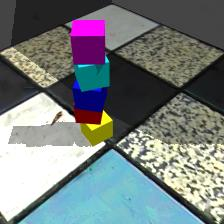

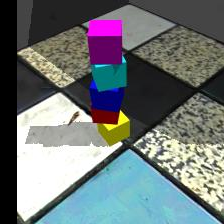

Source Image:,"(224, 224)"
Resized Padded Image:,"(224, 224)"


Original transform:
 Compose(
    RandomResizedCropAndInterpolation(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bicubic)
    RandomHorizontalFlip(p=0.5)
    ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.6, 1.4), hue=None)
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)
Train transform:
 Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=(0, 0, 0))
    Compose(
    RandomResizedCropAndInterpolation(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bicubic)
    RandomHorizontalFlip(p=0.5)
    ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.6, 1.4), hue=None)
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)
)
Val transform:
 Compose(
    Resize(size=235, interpolation=bicubic, max_size=None, antialias=True)
    CenterC

In [ ]:
# initialise the pretrained model

pretrained = True
model = create_model(pretrained)

# load the original train and validation transforms from the hugging face library
transform = create_transform(model, False)
val_tfms = create_transform(model, True)

# create the data augmentation transform
trivial_aug = data_augmentation(transform, data)

# conbime original and new transform to be the train transform
train_tfms = transforms.Compose([
      trivial_aug,
      transform
    ])

print('Original transform:\n', transform)
print('Train transform:\n', train_tfms)
print('Val transform:\n', val_tfms)


# create dataloaders
test = False
train_loader = create_data_loader(train_tfms, train_df, test, True)
val_loader = create_data_loader(val_tfms, val_df, test, False)

In [48]:
# summary(model, (3, 224, 224))

In [ ]:
# File path to save the log
log_file_path = '/kaggle/working/log.txt'

In [ ]:
# set device to GPU if available and move the model to it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# # define loss and optimiser
# different criterion if adding class weight
# weights = torch.tensor(weights, dtype=torch.float32).to(device)
# tr_criterion = nn.CrossEntropyLoss(weight=weights)  # For training
# val_criterion = nn.CrossEntropyLoss()  # For validation
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
no_dataaug_losses = []
no_dataaug_accuracies = []
best_val_loss = float('inf')  # current best validation loss, initializing it with a very large value
num_epochs = 50

for epoch in range(num_epochs):
    model.train() # set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels, id in train_loader:
        # put the images and labels on the device
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad() 

        # forward pass 
        outputs = model(images)
        loss = criterion(outputs, labels) # compute loss

        # backward pass and optimization
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # get predicted class (the index of the max log-probability)
        _, predicted_classes = torch.max(outputs, 1)
        correct_train += (predicted_classes == labels).sum().item()
        total_train += labels.size(0)

    average_train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(average_train_loss)
    train_accuracies.append(train_accuracy)

    # evaluation phase
    model.eval() # set the model to evaluation mode 
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    # for storing the predictions of the validation set
    all_val_ids = []
    all_val_preds = [] 
    with torch.no_grad():
        for images, labels, id in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            val_loss = criterion(outputs, labels)
            running_val_loss += val_loss.item()

            # get predicted class
            _, predicted_classes = torch.max(outputs, 1)
            correct_val += (predicted_classes == labels).sum().item()
            
            # store the predicted heights and corresponding image ids
            all_val_preds.extend(predicted_classes.cpu().numpy()) 
            all_val_ids.extend(id.cpu().numpy())  
                
            total_val += labels.size(0)


    average_val_loss = running_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(average_val_loss)
    val_accuracies.append(val_accuracy)

    # randomly sample some training images and applied val transform on them, feeding them into the model
    # ------------------------------------------------------------------------------    
    model.eval()  # make sure the model is in evaluation mode
    sampled_images, sampled_labels = [], []

    # randomly sample 1/10 rows from the training dataset
    num_sample = len(data)//10
    sampled_indices = random.sample(range(len(train_df)), num_sample)
    
    # extract the images and labels for those samples
    for idx in sampled_indices:
        # get image, label, and id from the dataset
        id = train_df.iloc[idx]['id']
        image = Image.open(root+'/'+str(id)+'.jpg')
        label = train_df.iloc[idx]['stable_height']  
        sampled_images.append(val_tfms(image))  # apply validation transforms to the image
        sampled_labels.append(label)

    # convert sampled images and labels to tensors
    sampled_images = torch.stack(sampled_images).to(device)
    sampled_labels = torch.tensor(sampled_labels).to(device)

    # forward pass through the model with sampled images
    with torch.no_grad():
        outputs = model(sampled_images)
        no_dataaug_loss = criterion(outputs, sampled_labels)

        # store loss
        no_dataaug_losses.append(no_dataaug_loss.item())

        # calculate accuracy
        _, predicted_classes = torch.max(outputs, 1)
        correct = (predicted_classes == sampled_labels).sum().item()
        no_dataaug_accuracy = correct / num_sample
        no_dataaug_accuracies.append(no_dataaug_accuracy)    
    # ------------------------------------------------------------------------------    
    
    # save the model is the validation loss is lower than the best loss we have 
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        torch.save(model.state_dict(), f'/kaggle/working/resnet50_epoch_{epoch + 1}.pth')

    print(f"\nEpoch {epoch+1}/{num_epochs}, "
          f"\nTrain Loss: {average_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"\nVal Loss: {average_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, "
          f"\nNo data aug Loss: {no_dataaug_loss:.4f}, No data aug Accuracy: {no_dataaug_accuracy:.4f}")

    # write the results to the log file
    with open(log_file_path, 'a') as f:
        f.write(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {average_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, "
          f"No data aug Loss: {no_dataaug_loss:.4f}, No data aug Accuracy: {no_dataaug_accuracy:.4f}\n")


Epoch 1/50, 
Train Loss: 1.7004, Train Accuracy: 0.2493, 
Val Loss: 1.6339, Val Accuracy: 0.2474, 
No data aug Loss: 1.6139, No data aug Accuracy: 0.2578

Epoch 2/50, 
Train Loss: 1.6263, Train Accuracy: 0.2640, 
Val Loss: 1.5827, Val Accuracy: 0.3014, 
No data aug Loss: 1.5592, No data aug Accuracy: 0.3073

Epoch 3/50, 
Train Loss: 1.5846, Train Accuracy: 0.3021, 
Val Loss: 1.5353, Val Accuracy: 0.3034, 
No data aug Loss: 1.5287, No data aug Accuracy: 0.2930

Epoch 4/50, 
Train Loss: 1.5601, Train Accuracy: 0.3228, 
Val Loss: 1.4095, Val Accuracy: 0.4017, 
No data aug Loss: 1.3662, No data aug Accuracy: 0.4284

Epoch 5/50, 
Train Loss: 1.5325, Train Accuracy: 0.3319, 
Val Loss: 1.4647, Val Accuracy: 0.3639, 
No data aug Loss: 1.4848, No data aug Accuracy: 0.3490

Epoch 6/50, 
Train Loss: 1.5084, Train Accuracy: 0.3330, 
Val Loss: 1.3698, Val Accuracy: 0.4271, 
No data aug Loss: 1.3683, No data aug Accuracy: 0.4375

Epoch 7/50, 
Train Loss: 1.5026, Train Accuracy: 0.3428, 
Val Loss: 1

In [ ]:
# extract the real heights of the validation instances
real_heights = [val_df[val_df['id'] == id].iloc[0]['stable_height'] for id in all_val_ids]

# label ranges from 0 to 5, so remember to add one to the estimated heights
all_val_preds = list(map(lambda x:x+1, all_val_preds))
real_heights = list(map(lambda x:x+1, real_heights))
dct = {'id': all_val_ids, 'predicted height': all_val_preds, 'real height': real_heights}   

validation = pd.DataFrame(dct)
# save the validation predictions
validation.to_csv('val_pred.csv', index=False) 

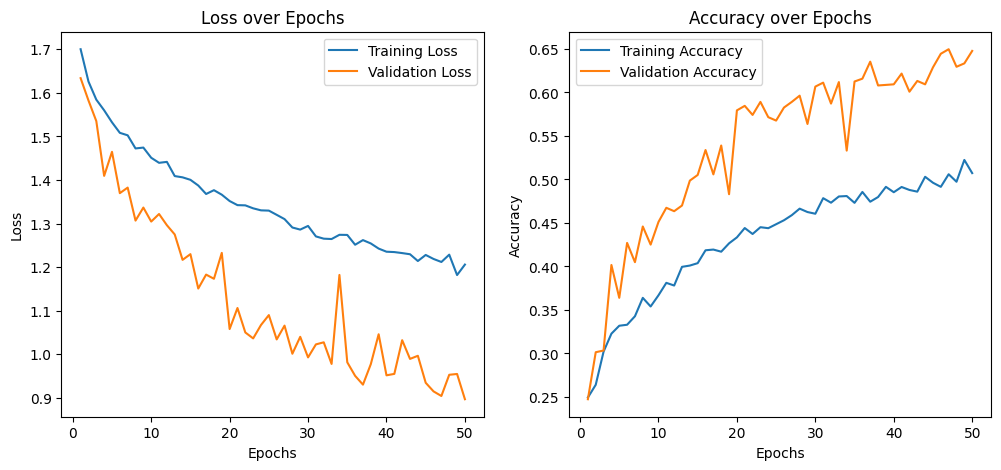

In [ ]:
# Plotting the loss and accuracy of training and validation set
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

# plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

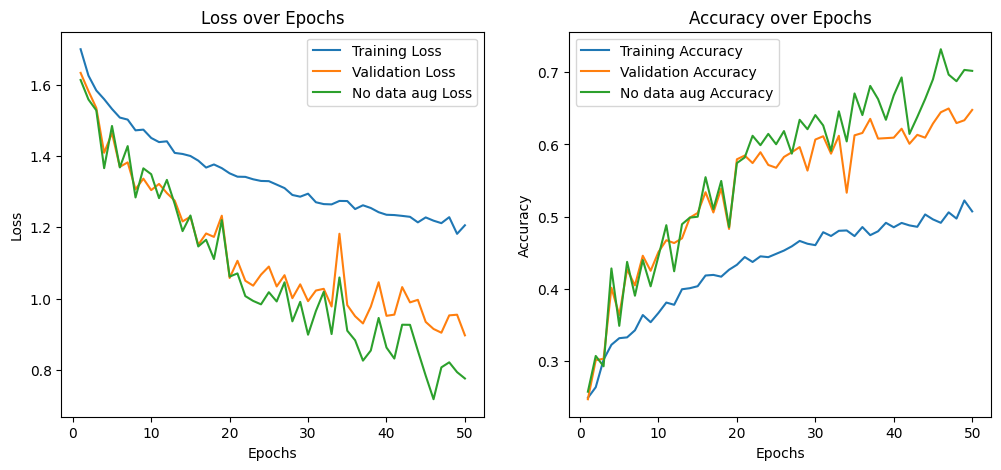

In [ ]:
# plot the outcomes of the sampled unaugmented images as well
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.plot(epochs, no_dataaug_losses, label='No data aug Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.plot(epochs, no_dataaug_accuracies, label='No data aug Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# save the final model
torch.save(model.state_dict(), '/kaggle/working/resnet50.pth')

## Test

In [ ]:
root = '/kaggle/input/comp90086-2024-project-test/test/test'

# load the test set
test_df = pd.read_csv('/kaggle/input/comp90086-2024-project-test/test.csv')

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class ImageTestDataset(Dataset):
    def __init__(self, df, root_dir, transform):
        self.df = df                # test dataframe
        self.root_dir = root_dir    # directory with images
        self.transform = transform  # any transformations (like resizing, normalization, etc.)
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get image file name (id) and the corresponding height (stable_height)
        img_id = str(self.df.iloc[idx]['id'])

        # construct the image file path
        img_path = os.path.join(self.root_dir, img_id + '.jpg')
        image = Image.open(img_path).convert("RGB")  # convert to RGB if the image is grayscale
        
        # apply transformations (if any)
        if self.transform:
            image = self.transform(image)

        return image, int(img_id)  # return image and height

In [ ]:
# use this if we start with a new session and want to load the model trained previously
# load the model architecture and modify it to be the same structure of our model

# model = timm.create_model('resnet50.a1_in1k', pretrained=False)
# num_classes = 6
# num_features = model.fc.in_features

# model.fc = nn.Sequential(
#   nn.Linear(num_features, 512),  
#   nn.ReLU(inplace=True),         
#   nn.Dropout(0.3),                
#   nn.Linear(512, 256),            
#   nn.ReLU(inplace=True),         
#   nn.Dropout(0.3),               
#   nn.Linear(256, num_classes)    
# )

# model.load_state_dict(torch.load('/kaggle/input/resnet50_new/pytorch/default/1/resnet50_new.pth', 
#                                  map_location=device,
#                                  weights_only=True))

# if we are using the same session, simply set the model to evaluation mode
model.eval()  

# load the original transform from hugging face library
transform = create_transform(model, True)
print('Original transform:\n', transform)

# no data augmentation on the testing set
test_tfms = transform
print('Test transform:\n', test_tfms)

# create the dataloader without shuffle
test = True
shuffle = False
test_loader = create_data_loader(test_tfms, test_df, test, shuffle)

Original transform:
 Compose(
    Resize(size=235, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)
Test transform:
 Compose(
    Resize(size=235, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)
Number of batches per epoch: 30, Shuffle: False


In [ ]:
predictions = []
ids = []

with torch.no_grad():  # disable gradient calculation 
    for images, id in test_loader:
        images = images.to(device)  # move images to GPU if available
        id = id.to(device)
        outputs = model(images)     # get model predictions 
        
        # get the predicted class (index of the max probability)
        _, predicted_classes = torch.max(outputs, 1)        
        predictions.extend(predicted_classes.cpu().numpy()) # append predictions to list
        ids.extend(id.cpu()) # append id to list

In [ ]:
# convert the predicted heights to a list and plus one
stable_height = list(map(lambda x:x+1, predictions))
test_df['stable_height'] = stable_height
test_df.head(30)

,id,stable_height
0,95,5
1,706,2
2,2854,1
3,3093,5
4,4283,3
5,5449,1
6,5625,2
7,7860,1
8,8051,1
9,8812,1


In [ ]:
# save the results
test_df.to_csv('result.csv', index=False) 

## Error analysis

In [ ]:
# load the validation result
error = pd.read_csv('/kaggle/input/val-pred-new/val_pred_new.csv')
error.head()

,id,predicted height,real height
0,788902,2,2
1,586509,3,3
2,210276,3,3
3,633089,4,4
4,464856,6,3


In [66]:
error = validation

In [67]:
error['real height'].value_counts()

real height
1    384
2    384
3    307
4    230
5    154
6     77
Name: count, dtype: int64

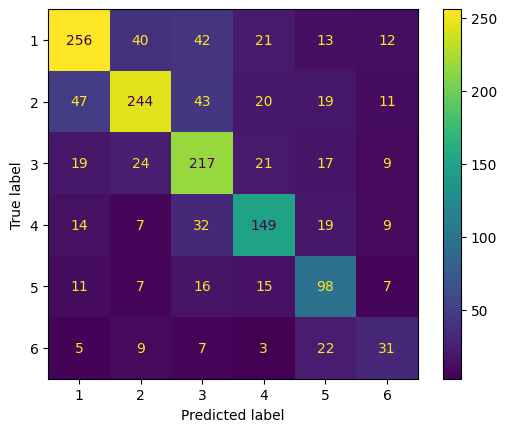

In [ ]:
# confusion matrix
confusion_matrix = metrics.confusion_matrix(error['real height'], error['predicted height'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, 2, 3, 4, 5, 6])
cm_display.plot()

plt.show()

In [ ]:
# calculate metrics for each class4
accuracy = accuracy_score(error['real height'], error['predicted height'])
precision = precision_score(error['real height'], error['predicted height'], average=None)  
recall = recall_score(error['real height'], error['predicted height'], average=None)  
f1 = f1_score(error['real height'], error['predicted height'], average=None)

print("Accuracy:", accuracy)
print("Precision for each class:", precision)
print("Recall for each class:", recall)
print("F1-score:", f1)

Accuracy: 0.6477864583333334
Precision for each class: [0.72727273 0.73716012 0.60784314 0.65065502 0.5212766  0.39240506]
Recall for each class: [0.66666667 0.63541667 0.70684039 0.64782609 0.63636364 0.4025974 ]
F1-score: [0.69565217 0.68251748 0.65361446 0.64923747 0.57309942 0.3974359 ]


## Feature map extraction

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create the model
model = timm.create_model('resnet50.a1_in1k', pretrained=False)
num_classes = 6
num_features = model.fc.in_features

model.fc = nn.Sequential(
  nn.Linear(num_features, 512),   
  nn.ReLU(inplace=True),         
  nn.Dropout(0.3),               
  nn.Linear(512, 256),           
  nn.ReLU(inplace=True),          
  nn.Dropout(0.3),               
  nn.Linear(256, num_classes)    
)

# load the model state dict
model.load_state_dict(torch.load('/kaggle/input/resnet50_new/pytorch/default/1/resnet50_new.pth', 
                                 map_location=device,
                                 weights_only=True))

<All keys matched successfully>

A hook is a mechanism in PyTorch to access the intermediate outputs (like feature maps) or gradients of specific layers during the forward or backward pass.



- Forward hooks: to capture the output (activation/feature map) of a layer during the forward pass.

- Backward hooks: to capture the gradients during the backward pass.

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


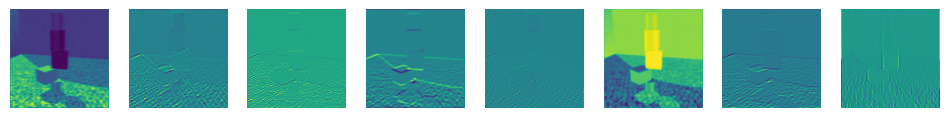

Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)


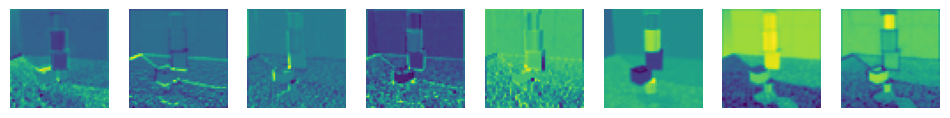

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


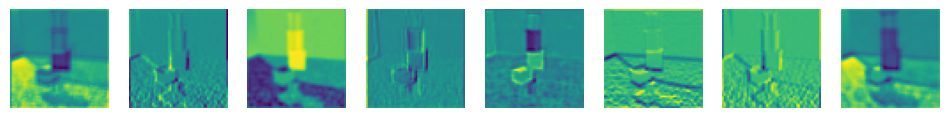

Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


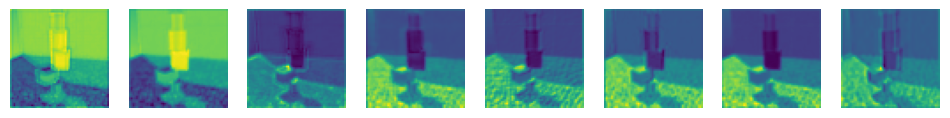

Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


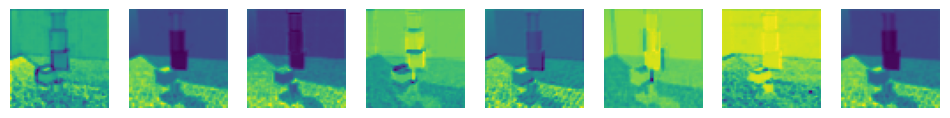

Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)


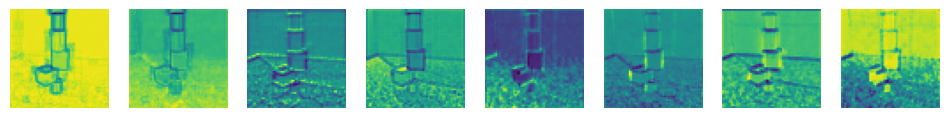

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


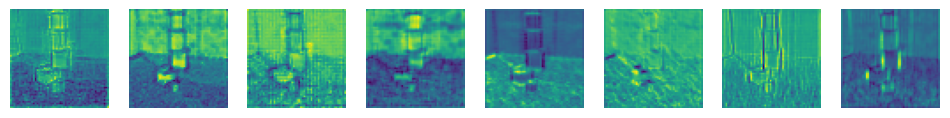

Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


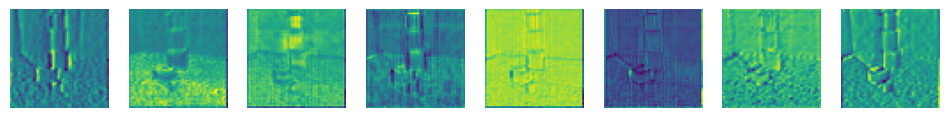

Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)


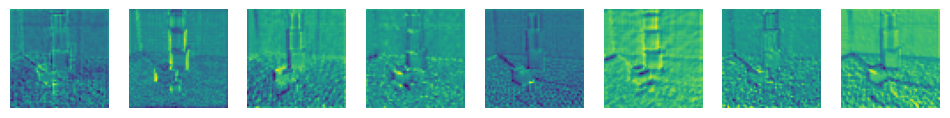

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


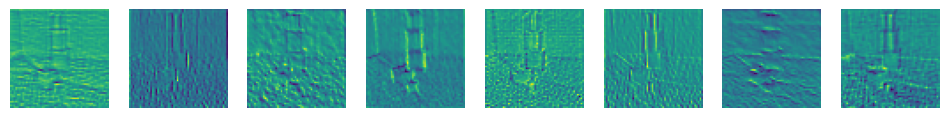

Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


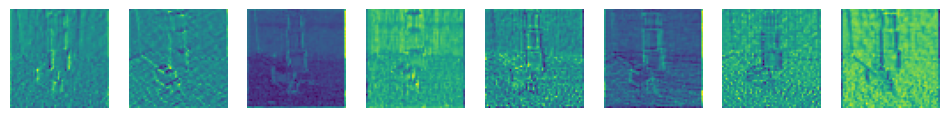

Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)


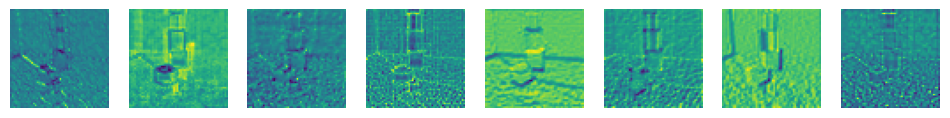

Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)


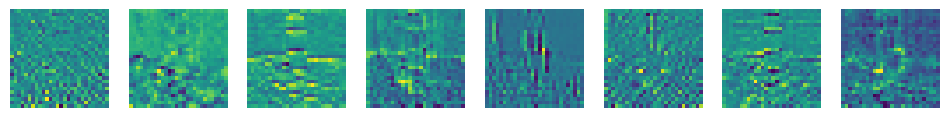

Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)


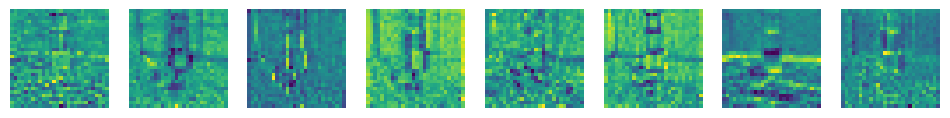

Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)


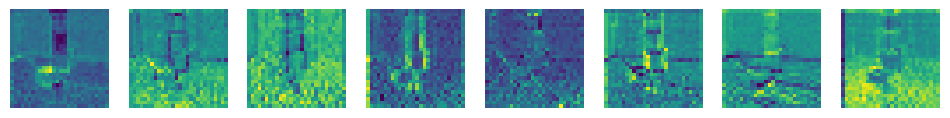

Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)


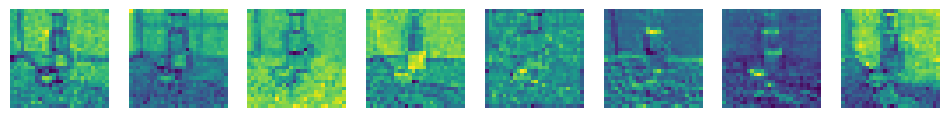

Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


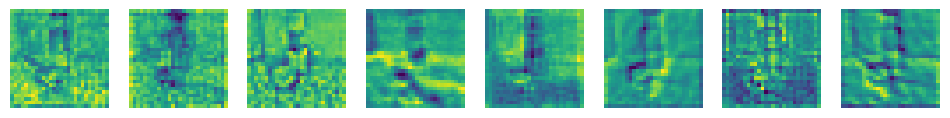

Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)


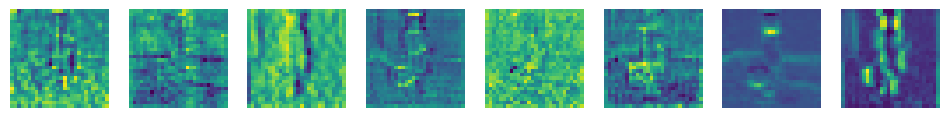

Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)


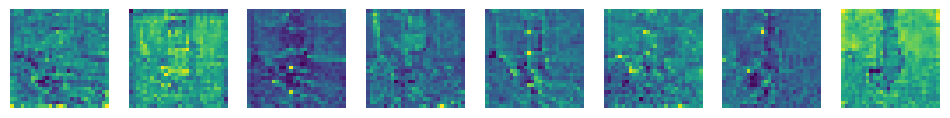

Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


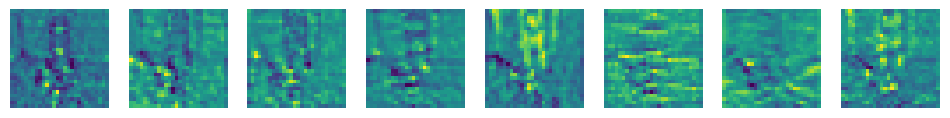

Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)


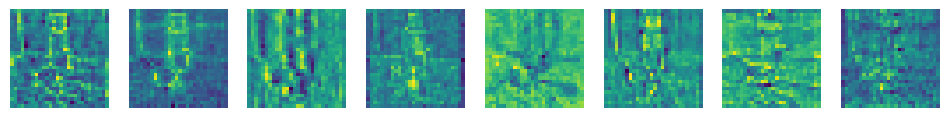

Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)


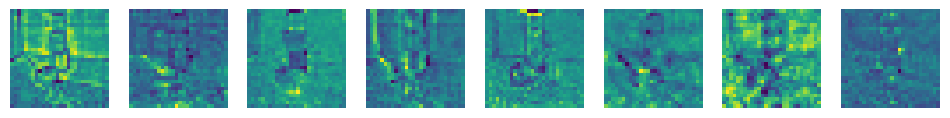

Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


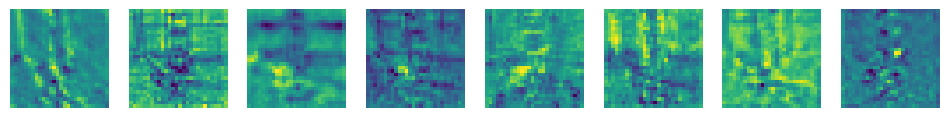

Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)


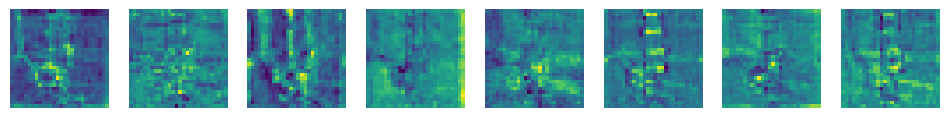

Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


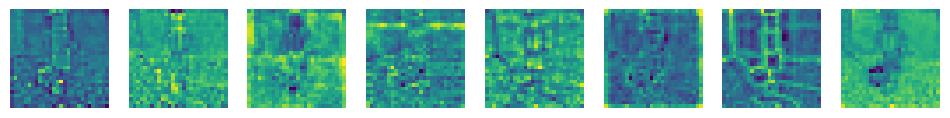

Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)


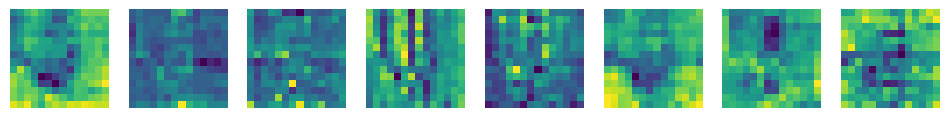

Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)


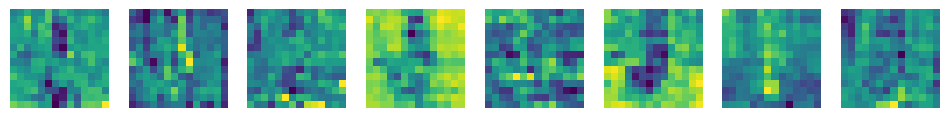

Conv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), bias=False)


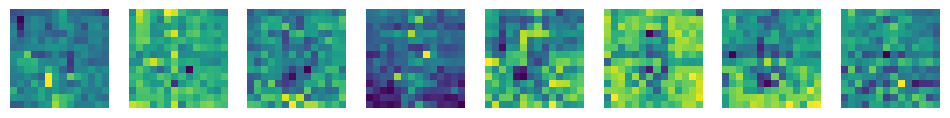

Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


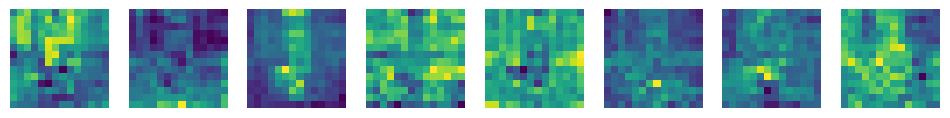

Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


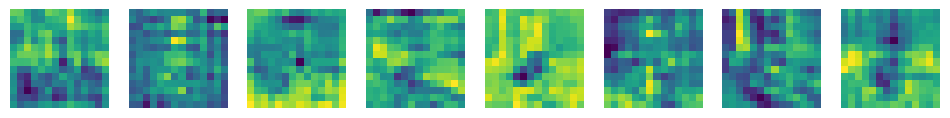

Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)


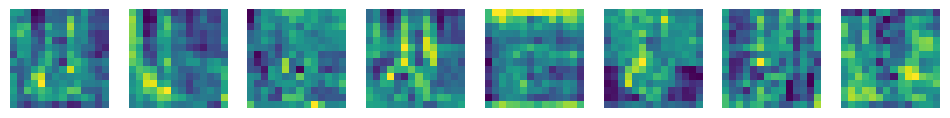

Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


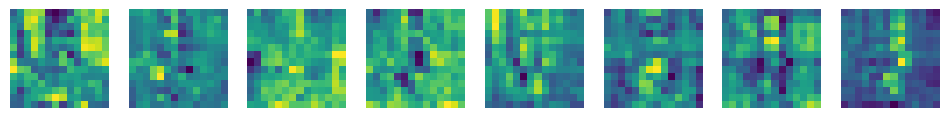

Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


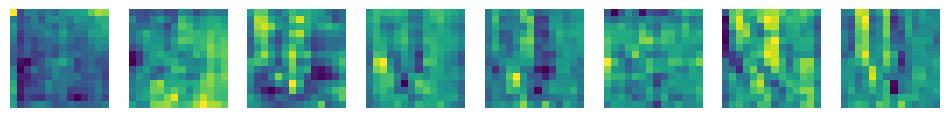

Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)


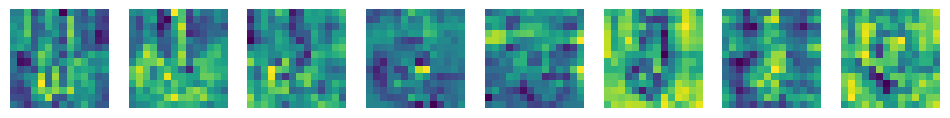

Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


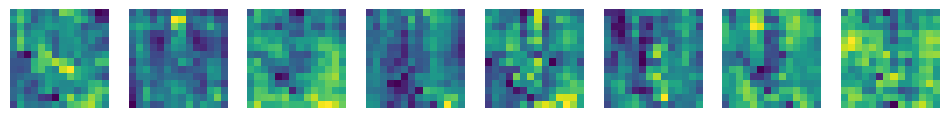

Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


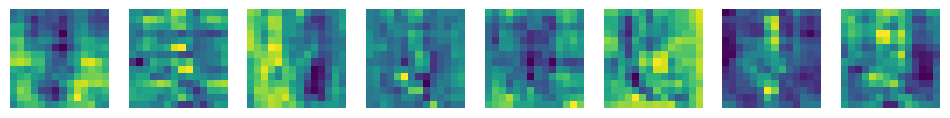

Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)


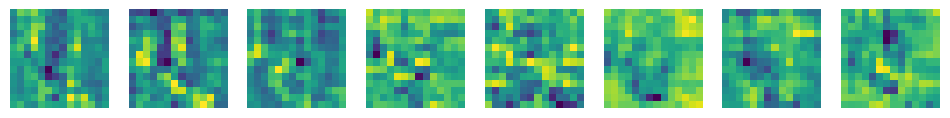

Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


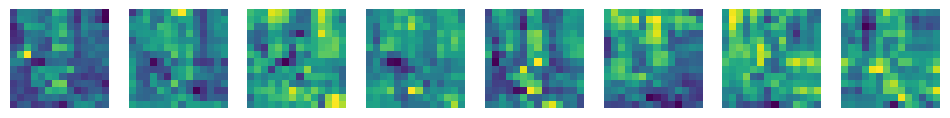

Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


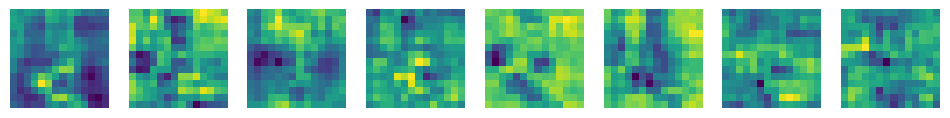

Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)


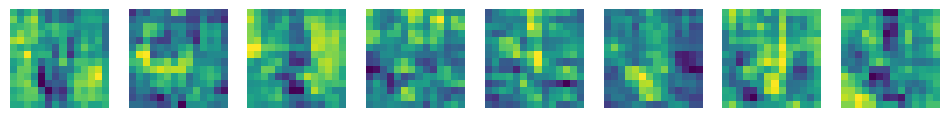

Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


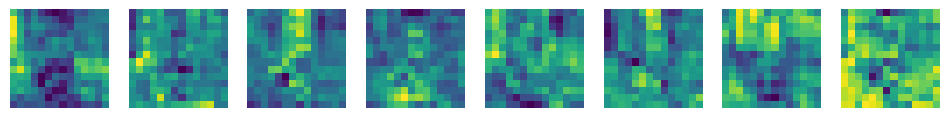

Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


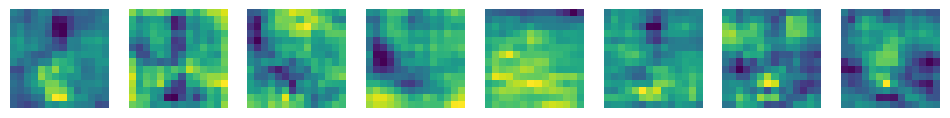

Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)


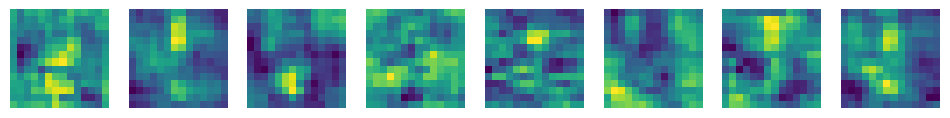

Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)


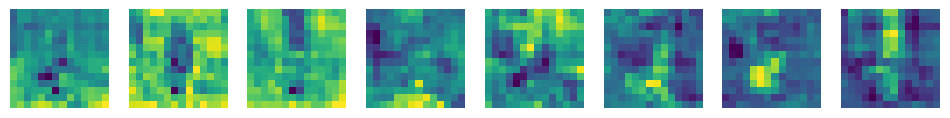

Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)


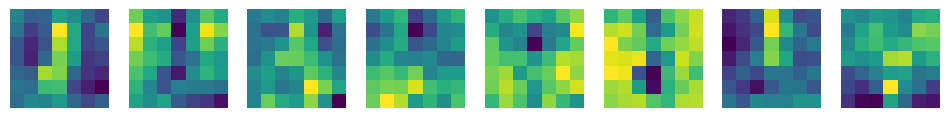

Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)


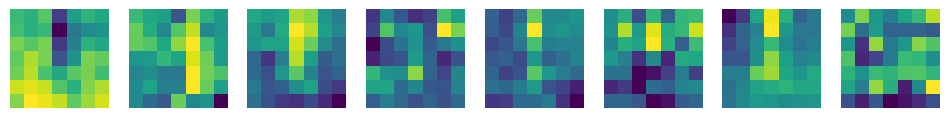

Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)


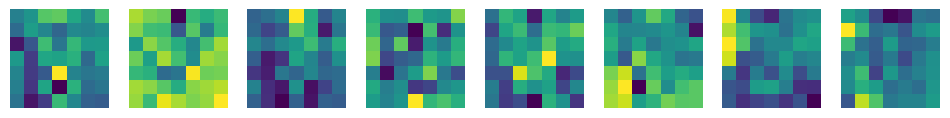

Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)


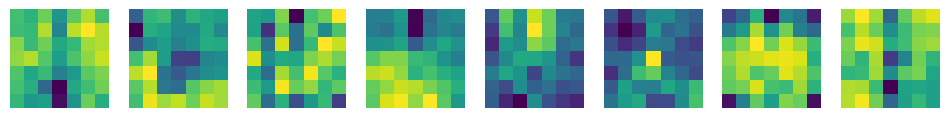

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


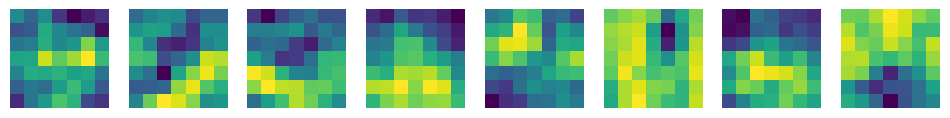

Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)


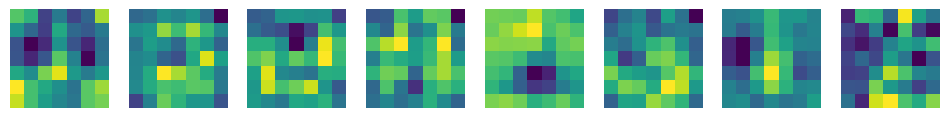

Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)


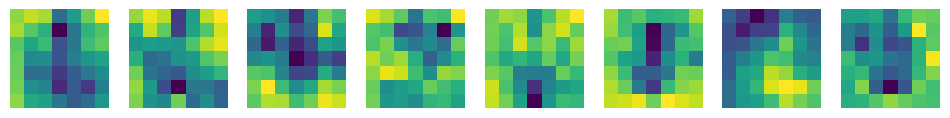

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


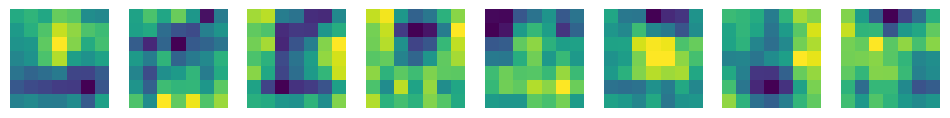

Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)


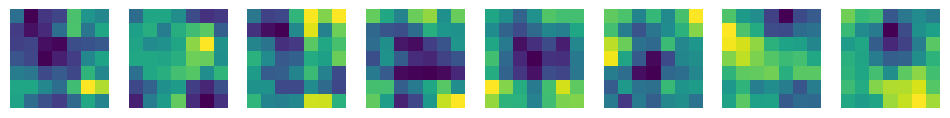

In [ ]:
# function to register forward hooks to layers
# once registered, this hook will be called every time a forward pass goes through that specific layer.
def register_hooks(model):
    activation = {}
   
    def hook_fn(module, input, output):
        # detach() gets the output without keeping track of gradients as we only need the activations
        activation[module] = output.detach()         

    for layer in model.modules():
        if isinstance(layer, torch.nn.Conv2d):  # register hook to Conv layers only
            layer.register_forward_hook(hook_fn)
    return activation

# visualize the feature map
def visualize_feature_map(activation, image_idx=0):
    for layer, feature_map in activation.items():
        print(layer)
        feature_map = feature_map[image_idx]  # select the feature map of the chosen image
        fig, axes = plt.subplots(1, min(8, feature_map.shape[0]), figsize=(12, 6))

        for i, ax in enumerate(axes):
            ax.imshow(feature_map[i].cpu().numpy(), cmap='viridis')
            ax.axis('off')

        plt.show()

model.eval()  # set model to evaluation mode

# load an image from the validation set
images, _, _ = next(iter(val_loader))
image = images[0].unsqueeze(0)  # select a single image
image = image.to(device)

# register hooks to all layers and get activations
# when doing a forward pass, the hooks will automatically store the feature maps in the activation dictionary.
activations = register_hooks(model)

# forward pass through the model
_ = model(image)

# visualize the feature maps
visualize_feature_map(activations)